In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

from sklearn.model_selection import train_test_split

## Import dataset

In [22]:
df = pd.read_csv("data/daily_min_temp.csv", index_col="Date", parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


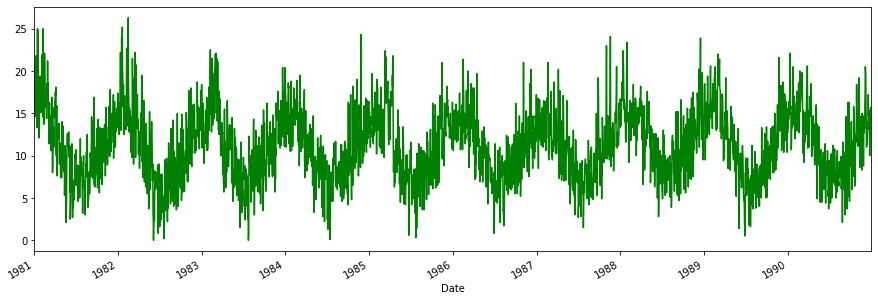

In [23]:
df.Temp.plot(figsize=(15,5), color='g');

## Dataset Splitting

In [24]:
## Pada data time series data tidak boleh dishuffle(diacak) 
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

## Dataset dan Dataloader

In [25]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [26]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, 'Temp', seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, 'Temp', seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



- N = Jumlah data
- S = Squence
- F = Feature

## Arsitektur dan config

In [34]:
class RNN(nn.Module):
    def __init__(self, input_size,output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [35]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size":1,
    "hidden_size":64,
    "num_layers":2,
    "dropout":0
})

## Training Preparation

In [39]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/rnn")

## Training

In [40]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 125.6812 | Test_cost  = 108.1914 | 




Epoch     2
Train_cost  = 89.3320 | Test_cost  = 79.9419 | 




Epoch     3
Train_cost  = 67.2625 | Test_cost  = 63.9612 | 




Epoch     4
Train_cost  = 54.8474 | Test_cost  = 54.4817 | 




Epoch     5
Train_cost  = 47.1570 | Test_cost  = 47.9051 | 




Epoch     6
Train_cost  = 41.5594 | Test_cost  = 42.6791 | 




Epoch     7
Train_cost  = 37.0238 | Test_cost  = 38.2847 | 




Epoch     8
Train_cost  = 33.2123 | Test_cost  = 34.5420 | 




Epoch     9
Train_cost  = 29.9950 | Test_cost  = 31.3646 | 




Epoch    10
Train_cost  = 27.2966 | Test_cost  = 28.6867 | 




Epoch    11
Train_cost  = 25.0537 | Test_cost  = 26.4474 | 




Epoch    12
Train_cost  = 23.2066 | Test_cost  = 24.5887 | 




Epoch    13
Train_cost  = 21.6994 | Test_cost  = 23.0573 | 




Epoch    14
Train_cost  = 20.4812 | Test_cost  = 21.8046 | 




Epoch    15
Train_cost  = 19.5060 | Test_cost  = 20.7870 | 




Epoch    16
Train_cost  = 18.7329 | Test_cost  = 19.9659 | 




Epoch    17
Train_cost  = 18.1260 | Test_cost  = 19.3077 | 




Epoch    18
Train_cost  = 17.6544 | Test_cost  = 18.7830 | 




Epoch    19
Train_cost  = 17.2913 | Test_cost  = 18.3669 | 




Epoch    20
Train_cost  = 17.0146 | Test_cost  = 18.0383 | 


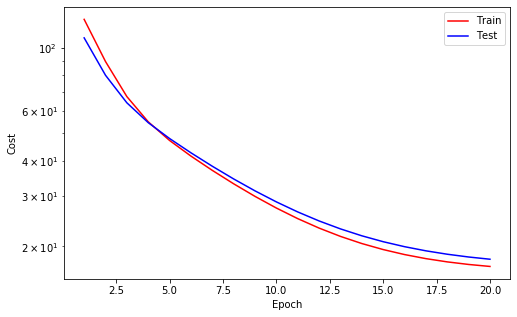



Epoch    21
Train_cost  = 16.8055 | Test_cost  = 17.7798 | 




Epoch    22
Train_cost  = 16.6488 | Test_cost  = 17.5769 | 




Epoch    23
Train_cost  = 16.5323 | Test_cost  = 17.4178 | 




Epoch    24
Train_cost  = 16.4461 | Test_cost  = 17.2931 | 




Epoch    25
Train_cost  = 16.3825 | Test_cost  = 17.1953 | 




Epoch    26
Train_cost  = 16.3357 | Test_cost  = 17.1182 | 




Epoch    27
Train_cost  = 16.3010 | Test_cost  = 17.0573 | 




Epoch    28
Train_cost  = 16.2749 | Test_cost  = 17.0089 | 




Epoch    29
Train_cost  = 16.2550 | Test_cost  = 16.9700 | 




Epoch    30
Train_cost  = 16.2393 | Test_cost  = 16.9384 | 




Epoch    31
Train_cost  = 16.2262 | Test_cost  = 16.9122 | 




Epoch    32
Train_cost  = 16.2146 | Test_cost  = 16.8901 | 




Epoch    33
Train_cost  = 16.2037 | Test_cost  = 16.8706 | 




Epoch    34
Train_cost  = 16.1926 | Test_cost  = 16.8526 | 




Epoch    35
Train_cost  = 16.1802 | Test_cost  = 16.8346 | 




Epoch    36
Train_cost  = 16.1653 | Test_cost  = 16.8149 | 




Epoch    37
Train_cost  = 16.1455 | Test_cost  = 16.7900 | 




Epoch    38
Train_cost  = 16.1160 | Test_cost  = 16.7516 | 




Epoch    39
Train_cost  = 16.0637 | Test_cost  = 16.6752 | 




Epoch    40
Train_cost  = 15.9454 | Test_cost  = 16.4609 | 


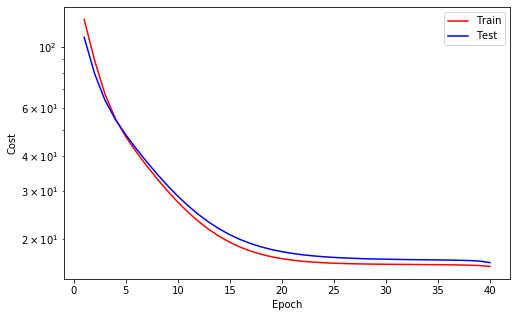



Epoch    41
Train_cost  = 15.5493 | Test_cost  = 15.5846 | 




Epoch    42
Train_cost  = 14.2747 | Test_cost  = 15.2021 | 




Epoch    43
Train_cost  = 13.7358 | Test_cost  = 14.2044 | 




Epoch    44
Train_cost  = 13.1794 | Test_cost  = 13.4037 | 




Epoch    45
Train_cost  = 12.4694 | Test_cost  = 12.6869 | 




Epoch    46
Train_cost  = 11.8674 | Test_cost  = 11.9582 | 




Epoch    47
Train_cost  = 11.2640 | Test_cost  = 11.3468 | 




Epoch    48
Train_cost  = 10.8091 | Test_cost  = 10.7266 | 




Epoch    49
Train_cost  = 10.3520 | Test_cost  = 10.2476 | 




Epoch    50
Train_cost  = 10.0026 | Test_cost  = 9.8374 | 




Epoch    51
Train_cost  = 9.7087 | Test_cost  = 9.4508 | 




Epoch    52
Train_cost  = 9.4215 | Test_cost  = 9.1269 | 




Epoch    53
Train_cost  = 9.1787 | Test_cost  = 8.8388 | 




Epoch    54
Train_cost  = 8.9710 | Test_cost  = 8.5693 | 




Epoch    55
Train_cost  = 8.7781 | Test_cost  = 8.3304 | 




Epoch    56
Train_cost  = 8.6040 | Test_cost  = 8.1240 | 




Epoch    57
Train_cost  = 8.4556 | Test_cost  = 7.9406 | 




Epoch    58
Train_cost  = 8.3273 | Test_cost  = 7.7715 | 




Epoch    59
Train_cost  = 8.2079 | Test_cost  = 7.6155 | 




Epoch    60
Train_cost  = 8.0919 | Test_cost  = 7.4741 | 


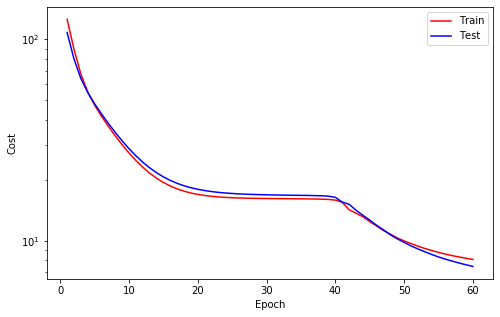



Epoch    61
Train_cost  = 7.9810 | Test_cost  = 7.3462 | 




Epoch    62
Train_cost  = 7.8781 | Test_cost  = 7.2300 | 




Epoch    63
Train_cost  = 7.7835 | Test_cost  = 7.1236 | 




Epoch    64
Train_cost  = 7.6966 | Test_cost  = 7.0256 | 




Epoch    65
Train_cost  = 7.6168 | Test_cost  = 6.9351 | 




Epoch    66
Train_cost  = 7.5437 | Test_cost  = 6.8514 | 




Epoch    67
Train_cost  = 7.4765 | Test_cost  = 6.7737 | 




Epoch    68
Train_cost  = 7.4146 | Test_cost  = 6.7014 | 




Epoch    69
Train_cost  = 7.3573 | Test_cost  = 6.6338 | 




Epoch    70
Train_cost  = 7.3040 | Test_cost  = 6.5705 | 




Epoch    71
Train_cost  = 7.2544 | Test_cost  = 6.5112 | 




Epoch    72
Train_cost  = 7.2080 | Test_cost  = 6.4553 | 




Epoch    73
Train_cost  = 7.1645 | Test_cost  = 6.4028 | 




Epoch    74
Train_cost  = 7.1237 | Test_cost  = 6.3532 | 




Epoch    75
Train_cost  = 7.0852 | Test_cost  = 6.3065 | 




Epoch    76
Train_cost  = 7.0488 | Test_cost  = 6.2624 | 




Epoch    77
Train_cost  = 7.0144 | Test_cost  = 6.2207 | 




Epoch    78
Train_cost  = 6.9817 | Test_cost  = 6.1814 | 




Epoch    79
Train_cost  = 6.9507 | Test_cost  = 6.1442 | 




Epoch    80
Train_cost  = 6.9213 | Test_cost  = 6.1091 | 


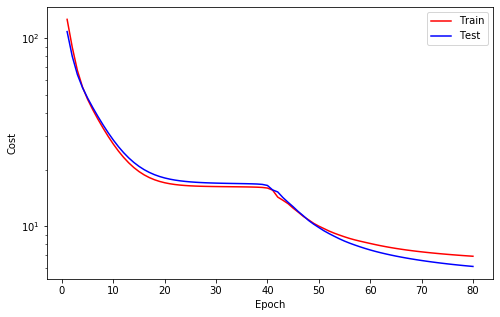



Epoch    81
Train_cost  = 6.8933 | Test_cost  = 6.0759 | 




Epoch    82
Train_cost  = 6.8667 | Test_cost  = 6.0444 | 




Epoch    83
Train_cost  = 6.8415 | Test_cost  = 6.0146 | 




Epoch    84
Train_cost  = 6.8175 | Test_cost  = 5.9863 | 




Epoch    85
Train_cost  = 6.7946 | Test_cost  = 5.9595 | 




Epoch    86
Train_cost  = 6.7728 | Test_cost  = 5.9340 | 




Epoch    87
Train_cost  = 6.7521 | Test_cost  = 5.9097 | 




Epoch    88
Train_cost  = 6.7323 | Test_cost  = 5.8865 | 




Epoch    89
Train_cost  = 6.7134 | Test_cost  = 5.8644 | 




Epoch    90
Train_cost  = 6.6954 | Test_cost  = 5.8432 | 




Epoch    91
Train_cost  = 6.6781 | Test_cost  = 5.8229 | 




Epoch    92
Train_cost  = 6.6616 | Test_cost  = 5.8035 | 




Epoch    93
Train_cost  = 6.6458 | Test_cost  = 5.7848 | 




Epoch    94
Train_cost  = 6.6306 | Test_cost  = 5.7669 | 




Epoch    95
Train_cost  = 6.6161 | Test_cost  = 5.7496 | 




Epoch    96
Train_cost  = 6.6021 | Test_cost  = 5.7329 | 




Epoch    97
Train_cost  = 6.5886 | Test_cost  = 5.7169 | 




Epoch    98
Train_cost  = 6.5756 | Test_cost  = 5.7014 | 




Epoch    99
Train_cost  = 6.5631 | Test_cost  = 5.6864 | 




Epoch   100
Train_cost  = 6.5511 | Test_cost  = 5.6719 | 


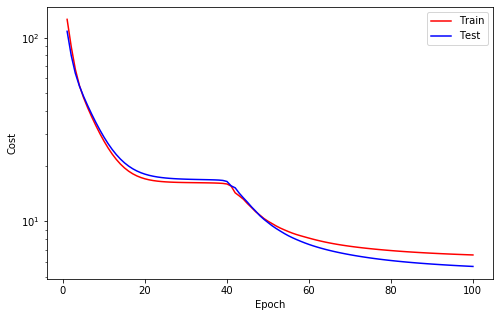



Epoch   101
Train_cost  = 6.5395 | Test_cost  = 5.6579 | 




Epoch   102
Train_cost  = 6.5282 | Test_cost  = 5.6443 | 




Epoch   103
Train_cost  = 6.5173 | Test_cost  = 5.6312 | 




Epoch   104
Train_cost  = 6.5068 | Test_cost  = 5.6184 | 




Epoch   105
Train_cost  = 6.4966 | Test_cost  = 5.6061 | 




Epoch   106
Train_cost  = 6.4867 | Test_cost  = 5.5941 | 




Epoch   107
Train_cost  = 6.4771 | Test_cost  = 5.5824 | 




Epoch   108
Train_cost  = 6.4678 | Test_cost  = 5.5710 | 




Epoch   109
Train_cost  = 6.4587 | Test_cost  = 5.5600 | 




Epoch   110
Train_cost  = 6.4499 | Test_cost  = 5.5492 | 




Epoch   111
Train_cost  = 6.4414 | Test_cost  = 5.5387 | 




Epoch   112
Train_cost  = 6.4330 | Test_cost  = 5.5285 | 




Epoch   113
Train_cost  = 6.4249 | Test_cost  = 5.5186 | 




Epoch   114
Train_cost  = 6.4169 | Test_cost  = 5.5089 | 




Epoch   115
Train_cost  = 6.4092 | Test_cost  = 5.4994 | 




Epoch   116
Train_cost  = 6.4016 | Test_cost  = 5.4901 | 




Epoch   117
Train_cost  = 6.3942 | Test_cost  = 5.4810 | 




Epoch   118
Train_cost  = 6.3870 | Test_cost  = 5.4721 | 




Epoch   119
Train_cost  = 6.3799 | Test_cost  = 5.4635 | 




Epoch   120
Train_cost  = 6.3730 | Test_cost  = 5.4550 | 


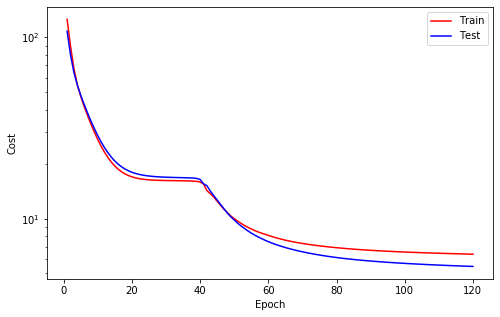



Epoch   121
Train_cost  = 6.3662 | Test_cost  = 5.4467 | 




Epoch   122
Train_cost  = 6.3595 | Test_cost  = 5.4385 | 




Epoch   123
Train_cost  = 6.3530 | Test_cost  = 5.4306 | 




Epoch   124
Train_cost  = 6.3466 | Test_cost  = 5.4228 | 




Epoch   125
Train_cost  = 6.3403 | Test_cost  = 5.4151 | 




Epoch   126
Train_cost  = 6.3341 | Test_cost  = 5.4076 | 




Epoch   127
Train_cost  = 6.3280 | Test_cost  = 5.4003 | 




Epoch   128
Train_cost  = 6.3221 | Test_cost  = 5.3931 | 




Epoch   129
Train_cost  = 6.3162 | Test_cost  = 5.3861 | 




Epoch   130
Train_cost  = 6.3105 | Test_cost  = 5.3792 | 




Epoch   131
Train_cost  = 6.3048 | Test_cost  = 5.3725 | 




Epoch   132
Train_cost  = 6.2992 | Test_cost  = 5.3659 | 




Epoch   133
Train_cost  = 6.2938 | Test_cost  = 5.3595 | 




Epoch   134
Train_cost  = 6.2884 | Test_cost  = 5.3531 | 




Epoch   135
Train_cost  = 6.2831 | Test_cost  = 5.3470 | 




Epoch   136
Train_cost  = 6.2778 | Test_cost  = 5.3409 | 




Epoch   137
Train_cost  = 6.2727 | Test_cost  = 5.3350 | 




Epoch   138
Train_cost  = 6.2677 | Test_cost  = 5.3293 | 




Epoch   139
Train_cost  = 6.2627 | Test_cost  = 5.3236 | 




Epoch   140
Train_cost  = 6.2578 | Test_cost  = 5.3181 | 


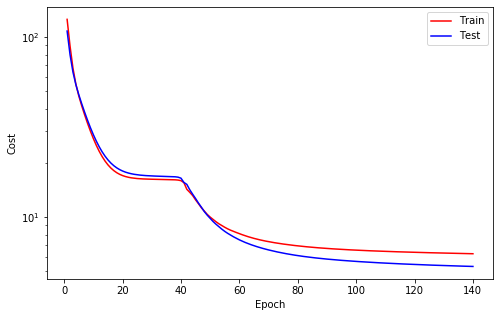



Epoch   141
Train_cost  = 6.2530 | Test_cost  = 5.3127 | 




Epoch   142
Train_cost  = 6.2482 | Test_cost  = 5.3075 | 




Epoch   143
Train_cost  = 6.2435 | Test_cost  = 5.3024 | 




Epoch   144
Train_cost  = 6.2389 | Test_cost  = 5.2974 | 




Epoch   145
Train_cost  = 6.2344 | Test_cost  = 5.2925 | 




Epoch   146
Train_cost  = 6.2299 | Test_cost  = 5.2877 | 




Epoch   147
Train_cost  = 6.2255 | Test_cost  = 5.2831 | 




Epoch   148
Train_cost  = 6.2211 | Test_cost  = 5.2786 | 




Epoch   149
Train_cost  = 6.2168 | Test_cost  = 5.2741 | 




Epoch   150
Train_cost  = 6.2126 | Test_cost  = 5.2699 | 




Epoch   151
Train_cost  = 6.2084 | Test_cost  = 5.2657 | 




Epoch   152
Train_cost  = 6.2043 | Test_cost  = 5.2616 | 




Epoch   153
Train_cost  = 6.2002 | Test_cost  = 5.2576 | 




Epoch   154
Train_cost  = 6.1962 | Test_cost  = 5.2538 | 




Epoch   155
Train_cost  = 6.1923 | Test_cost  = 5.2500 | 




Epoch   156
Train_cost  = 6.1883 | Test_cost  = 5.2464 | 




Epoch   157
Train_cost  = 6.1845 | Test_cost  = 5.2428 | 




Epoch   158
Train_cost  = 6.1806 | Test_cost  = 5.2394 | 




Epoch   159
Train_cost  = 6.1769 | Test_cost  = 5.2361 | 




Epoch   160
Train_cost  = 6.1731 | Test_cost  = 5.2328 | 


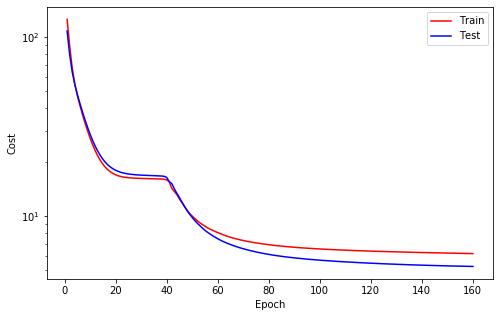



Epoch   161
Train_cost  = 6.1694 | Test_cost  = 5.2297 | 




Epoch   162
Train_cost  = 6.1657 | Test_cost  = 5.2266 | 




Epoch   163
Train_cost  = 6.1621 | Test_cost  = 5.2236 | 




Epoch   164
Train_cost  = 6.1585 | Test_cost  = 5.2208 | 




Epoch   165
Train_cost  = 6.1550 | Test_cost  = 5.2180 | 




Epoch   166
Train_cost  = 6.1514 | Test_cost  = 5.2153 | 




Epoch   167
Train_cost  = 6.1479 | Test_cost  = 5.2126 | 




Epoch   168
Train_cost  = 6.1445 | Test_cost  = 5.2101 | 




Epoch   169
Train_cost  = 6.1410 | Test_cost  = 5.2077 | 




Epoch   170
Train_cost  = 6.1376 | Test_cost  = 5.2053 | 




Epoch   171
Train_cost  = 6.1342 | Test_cost  = 5.2030 | 




Epoch   172
Train_cost  = 6.1309 | Test_cost  = 5.2008 | 




Epoch   173
Train_cost  = 6.1275 | Test_cost  = 5.1986 | 




Epoch   174
Train_cost  = 6.1242 | Test_cost  = 5.1966 | 




Epoch   175
Train_cost  = 6.1209 | Test_cost  = 5.1945 | 




Epoch   176
Train_cost  = 6.1176 | Test_cost  = 5.1926 | 




Epoch   177
Train_cost  = 6.1143 | Test_cost  = 5.1907 | 




Epoch   178
Train_cost  = 6.1111 | Test_cost  = 5.1889 | 




Epoch   179
Train_cost  = 6.1078 | Test_cost  = 5.1872 | 




Epoch   180
Train_cost  = 6.1046 | Test_cost  = 5.1855 | 


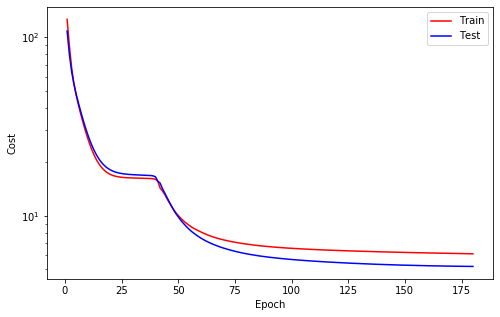



Epoch   181
Train_cost  = 6.1014 | Test_cost  = 5.1839 | 




Epoch   182
Train_cost  = 6.0982 | Test_cost  = 5.1824 | 




Epoch   183
Train_cost  = 6.0950 | Test_cost  = 5.1809 | 




Epoch   184
Train_cost  = 6.0918 | Test_cost  = 5.1794 | 




Epoch   185
Train_cost  = 6.0886 | Test_cost  = 5.1780 | 




Epoch   186
Train_cost  = 6.0854 | Test_cost  = 5.1767 | 




Epoch   187
Train_cost  = 6.0822 | Test_cost  = 5.1755 | 




Epoch   188
Train_cost  = 6.0790 | Test_cost  = 5.1742 | 




Epoch   189
Train_cost  = 6.0758 | Test_cost  = 5.1731 | 




Epoch   190
Train_cost  = 6.0727 | Test_cost  = 5.1720 | 




Epoch   191
Train_cost  = 6.0695 | Test_cost  = 5.1710 | 




Epoch   192
Train_cost  = 6.0663 | Test_cost  = 5.1700 | 




Epoch   193
Train_cost  = 6.0630 | Test_cost  = 5.1691 | 




Epoch   194
Train_cost  = 6.0598 | Test_cost  = 5.1682 | 




Epoch   195
Train_cost  = 6.0566 | Test_cost  = 5.1674 | 




Epoch   196
Train_cost  = 6.0533 | Test_cost  = 5.1666 | 




Epoch   197
Train_cost  = 6.0501 | Test_cost  = 5.1660 | 




Epoch   198
Train_cost  = 6.0468 | Test_cost  = 5.1654 | 




Epoch   199
Train_cost  = 6.0435 | Test_cost  = 5.1648 | 




Epoch   200
Train_cost  = 6.0401 | Test_cost  = 5.1643 | 


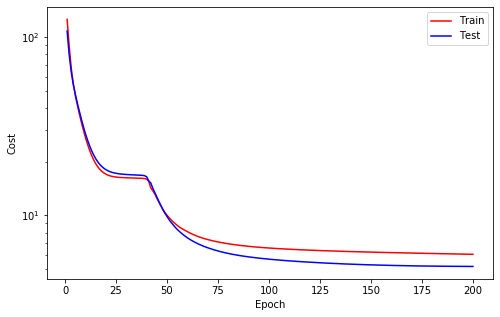



Epoch   201
Train_cost  = 6.0368 | Test_cost  = 5.1640 | 




Epoch   202
Train_cost  = 6.0334 | Test_cost  = 5.1636 | 




Epoch   203
Train_cost  = 6.0300 | Test_cost  = 5.1634 | 




Epoch   204
Train_cost  = 6.0265 | Test_cost  = 5.1632 | 




Epoch   205
Train_cost  = 6.0230 | Test_cost  = 5.1632 | 




Epoch   206
Train_cost  = 6.0195 | Test_cost  = 5.1632 | 
==> EarlyStop patience =  1 | Best test_cost: 5.1632




Epoch   207
Train_cost  = 6.0159 | Test_cost  = 5.1633 | 
==> EarlyStop patience =  2 | Best test_cost: 5.1632




Epoch   208
Train_cost  = 6.0122 | Test_cost  = 5.1635 | 
==> EarlyStop patience =  3 | Best test_cost: 5.1632




Epoch   209
Train_cost  = 6.0085 | Test_cost  = 5.1639 | 
==> EarlyStop patience =  4 | Best test_cost: 5.1632




Epoch   210
Train_cost  = 6.0047 | Test_cost  = 5.1643 | 
==> EarlyStop patience =  5 | Best test_cost: 5.1632
==> Execute Early Stopping at epoch: 210 | Best test_cost: 5.1632
==> Best model is saved at model/rnn


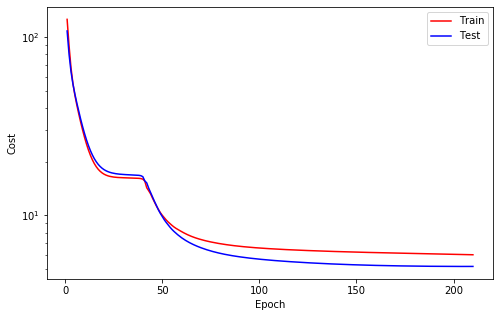

In [41]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

## Sanity Check

In [42]:
from utils import data4pred, pred4pred

In [45]:
train_forecast_set = TimeSeriesDataset(ts_train, 'Temp', 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, 'Temp', 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

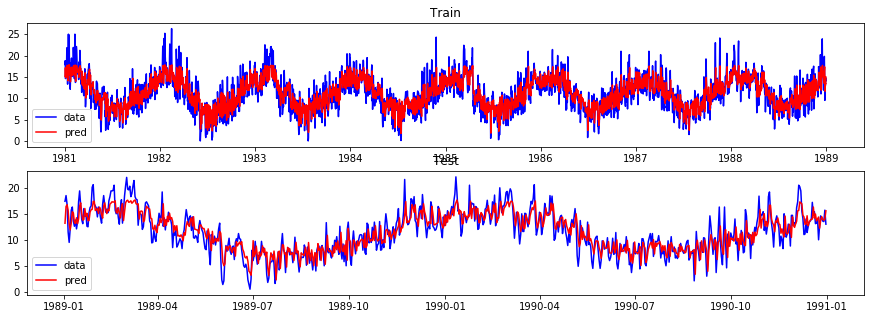

In [46]:
# Data For Pred
plt.figure(figsize=(15,5))

plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title('Train')

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

Text(0.5, 1.0, 'Test')

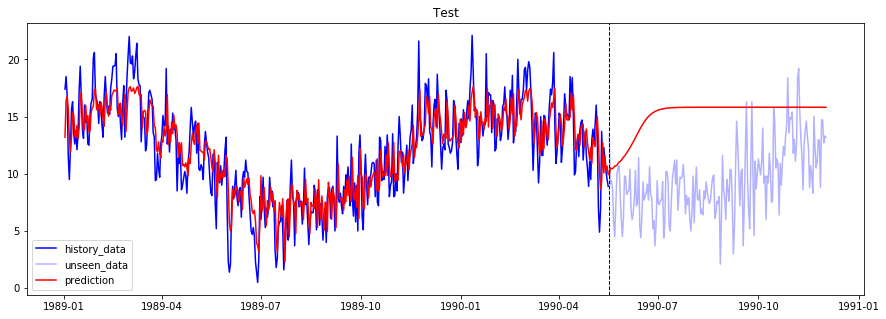

In [47]:
# Pred for pred
plt.figure(figsize=(15,5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title('Test')

#### Umumnya pred for pred hanya dapat memprediksi 2 hari kedepan. untuk hari selanjutnya tidak dipakai karena terjadi domino effect yang terjadi apabila disuatu hari tersebut terjadi kesalahan maka hari selanjutnya akan menjadi salah terus 